In [6]:
import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fnmatch
import os
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential
import glob
import pickle
import sys
import argparse

In [2]:
from ctapipe.io import EventSource
from ctapipe import utils

In [3]:

filePath="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
X = tables.open_file(filePath, mode="r")
#print(X.get_node('/dl1/event/telescope/images/tel_001').read())

In [7]:
Sample_Image_tel_001 =  X.get_node('/dl1/event/telescope/images/tel_001').read()[30][3]
print(np.shape(Sample_Image_tel_001))
#print(X.get_node('/dl1/event/telescope/images/tel_002').read()[40][3])

(960,)


In [4]:
#plt.plot(Sample_Image_tel_001)
#import dl1_data_handler
#grid = Sample_Image_tel_001.reshape((31,31))
#plt.imshow(grid, cmap='viridis')
#plt.colorbar()
#plt.show()
from ctapipe.instrument.camera import CameraGeometry

from dl1_data_handler.reader import DL1DataReader
from dl1_data_handler.image_mapper import ImageMapper


In [10]:
#reader = DL1DataReader(["../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/dl1_data_handler_demo/gamma_20deg_0deg_runs100-103___cta-prod3-demo_desert-2150m-Paranal-baseline-sample_cone10.h5"])
reader = DL1DataReader(["../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/dl1_data_handler_demo/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"])


OSError: ``/mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/dl1_data_handler_demo/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5`` does not exist

In [17]:
reader = DL1DataReader(["../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"])
print(dir(reader))
print(reader.example_description)
#print("Image shape: {}".format(reader[0][0].shape))

#print("Image shape: {}".format(reader[0][0].shape))
#print(reader.get_node('/dl1/event/telescope/images/tel_001').read()[30][3])

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_append_subarray_info', '_construct_simulated_info', '_construct_unprocessed_example_description', '_get_camera_type', '_get_image', '_v_attrs', 'class_weight', 'event_info', 'files', 'mode', 'shower_primary_id_to_name', 'subarray_info']


AttributeError: 'DL1DataReader' object has no attribute 'example_description'

In [13]:

# Define the camera types and mapping methods
hex_cams = ['LSTCam', 'FlashCam', 'NectarCam', 'DigiCam', 'VERITAS',
            'MAGICCam', 'FACT', 'HESS-I', 'HESS-II']
square_cams = ['SCTCam', 'CHEC', 'ASTRICam']
camera_types = hex_cams + square_cams
hex_methods = ['oversampling', 'rebinning', 'nearest_interpolation',
               'bilinear_interpolation', 'bicubic_interpolation', 
               'image_shifting', 'axial_addressing']
square_methods = ['oversampling', 'rebinning', 'nearest_interpolation',
                  'bilinear_interpolation', 'bicubic_interpolation']

In [14]:
# Load the image mappers
mappers = {}
print("Initialization time (total for all telescopes):")
for method in hex_methods:
    print(method)
    mapping_method = {cam: method for cam in hex_cams}
    for cam in square_cams:
        mapping_method[cam] = method if method in square_methods else 'oversampling'
    %timeit mappers[method] = ImageMapper(mapping_method=mapping_method)

Initialization time (total for all telescopes):
oversampling


FileNotFoundError: Couldn't find any file: LSTSiPMCam.camgeom[.fits.gz, .fits, .ecsv, .ecsv.txt]

In [18]:

from dl1_data_handler.writer import DL1DataWriter, CTAMLDataDumper

ImportError: cannot import name 'DataContainer' from 'ctapipe.containers' (/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/ctapipe/containers.py)

In [6]:
# Author:
# Hannes Warnhofer
# 22715256
# hannes.warnhofer@fau.de

# Test if GitHub Connection works as intended
lll = 1
# import relevant (and irrelevant) packages 
import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fnmatch
import os
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential
import glob
import pickle
import sys
import argparse

# Allow for arguments to be passed to the python file, when running it. This enables to define a series of runs with different model properties, by defining this in the respective batch script.
# Example for usage: srun python /home/hpc/b129dc/b129dc26/MoDA_Project/Hannes_Warnhofer_22715256_CTA_Multiview_Analysis_Cluster.py -n "345" -e 50 -b 512 -r 0.25 -reg 0.001
# This uses all the data that starts with 3,4 or 5, runs over 50 epochs, has a batch size of 512 and a dropout rate of .25 and a regularization of 0.001
# The following installations have to be done when running a batch script on Alex:
# module load python/tensorflow-2.7.0py3.9
# pip install --user tables
# pip install --user pandas
# pip install --user pickle
# pip install --user glob
# pip install --user sys
# pip install --user argparse

parser = argparse.ArgumentParser()
parser.add_argument("-n", "--numbers", type=str)
parser.add_argument("-e", "--epochs", type=int)
parser.add_argument("-b", "--batch_size", type=int)
parser.add_argument("-r", "--rate", type=float)
parser.add_argument("-reg", "--regulization", type=float)

args = parser.parse_args()
var1 = args.numbers
num_epochs = args.epochs
batch_size = args.batch_size
rate = args.rate
reg = args.regulization
patience = 5

# Define the appendix to the file, for being able to specify some general changes in the model structure and trace back the changes when comparing the results of t´different models
fnr = "_2023-02-27_" + var1 +'_only_earlystopping'

# Create file paths from the argument that specifies which data files to include
crit = '[' + var1 + ']*.hdf5'
file_paths = [f for f in glob.glob(os.path.join(cluster_filePath, crit))]


# load in the data
####################################

# define empty arrays
squared_training = []
peak_times = []
event_labels = []

# go through the file_paths of the includes files
for i in file_paths:
    with tables.open_file(i, mode="r") as x:
        # ignore the electron events
        mask_e = x.root.event_label[:] != 2 
        event_labels_temp = x.root.event_label[:][mask_e].reshape((-1, 1))
        squared_training_temp = x.root.squared_training[:,:,:,:][mask_e]
        peak_times_temp = x.root.peak_times[:,:,:,:][mask_e]

        # append all the data to a common array
        squared_training.append(squared_training_temp)
        peak_times.append(peak_times_temp)
        event_labels.append(event_labels_temp)

squared_training = np.concatenate(squared_training, axis=0)
peak_times = np.concatenate(peak_times, axis=0)
event_labels = np.concatenate(event_labels, axis=0)

# some reshaping for the further use of the timing data in the CNN
peak_times = peak_times.reshape((*np.shape(peak_times),1))

# overview about the important data array for later usage
print(np.shape(peak_times)[0], " events with 4 images each are available \n")
print("Shape of 'event_labels': ",np.shape(event_labels))
print("Shape of 'squared_training': ",np.shape(squared_training))
print("Shape of 'peak_times': ",np.shape(peak_times),"\n")

# split into random training data (80%) and test data (20%)
train_data, test_data, train_labels, test_labels = [], [], [], []
random_selection = np.random.rand(np.shape(peak_times)[0]) <= 0.8
train_data.append(peak_times[random_selection])
test_data.append(peak_times[~random_selection])
train_labels.append(event_labels[random_selection])
test_labels.append(event_labels[~random_selection])

# free some memory space
del peak_times
del event_labels

# convert to numpy array and reshape 
train_data = np.array(train_data)
train_data = train_data.reshape(np.shape(train_data[0]))
test_data = np.array(test_data)
test_data = test_data.reshape(np.shape(test_data[0]))

train_labels = np.array(train_labels)
train_labels = train_labels.reshape(np.shape(train_labels[0]))
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(np.shape(test_labels[0]))

train_labels_multishape = np.zeros_like(train_data)
test_labels_multishape = np.zeros_like(test_data)

len_train = np.shape(train_data)[0]
len_test = np.shape(test_data)[0]

for i in range(0,len_train):
    train_labels_multishape[i,:,:,:] = train_labels[i]

for k in range(0,len_test):
    test_labels_multishape[k,:,:,:] = test_labels[k]

# overvew about the splitting into training and test data
print("Split into Training and Test Data")
print("Train data shape:", np.shape(train_data) , "-->",round(100*len_train/(len_train+len_test),2),"%")
print("Test data shape:", np.shape(test_data), "-->",round(100*len_test/(len_train+len_test),2), "%")
print("Train labels shape:", np.shape(train_labels))
print("Test labels shape:", np.shape(test_labels))

# split up different "telescopes" for the usage in the seperate single view CNNs (probably in the most long-winded way possible, but lets just ignore that)
train_data_1 = train_data[:,0,:,:] 
train_data_2 = train_data[:,1,:,:] 
train_data_3 = train_data[:,2,:,:] 
train_data_4 = train_data[:,3,:,:] 

test_data_1 = test_data[:,0,:,:]
test_data_2 = test_data[:,1,:,:]
test_data_3 = test_data[:,2,:,:]
test_data_4 = test_data[:,3,:,:]

train_labels_1 = train_labels_multishape[:,0,:,:]
train_labels_2 = train_labels_multishape[:,1,:,:]
train_labels_3 = train_labels_multishape[:,2,:,:]
train_labels_4 = train_labels_multishape[:,3,:,:]

test_labels_1 = test_labels_multishape[:,0,:,:]
test_labels_2 = test_labels_multishape[:,1,:,:]
test_labels_3 = test_labels_multishape[:,2,:,:]
test_labels_4 = test_labels_multishape[:,3,:,:]

print("Train data 1 shape:", np.shape(train_data_1))
print("Train labels 1 shape:", np.shape(train_labels_1))

print("Test data 1 shape:", np.shape(test_data_1))
print("Test labels 1 shape:", np.shape(test_labels_1))

input_shape = (48, 48, 1)
pool_size = 2
kernel_size = 4

# Define the model for the single-view CNNs
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(filters=25, kernel_size=kernel_size, activation='relu', padding='same',kernel_regularizer=regularizers.l2(reg), input_shape=input_shape,))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    model.add(Dropout(rate))
    model.add(Conv2D(filters=50, kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=regularizers.l2(reg)))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    model.add(Dropout(rate))
    model.add(Conv2D(filters=50, kernel_size=kernel_size, activation='relu', padding='same',kernel_regularizer=regularizers.l2(reg)))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    model.add(Dropout(rate))
    model.add(Conv2D(filters=100, kernel_size=kernel_size, activation='relu', padding='same',kernel_regularizer=regularizers.l2(reg)))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    return model

# Define the model for the combination of the previous CNNs and the final CNN for classification

def run_multiview_model(models,inputs):

    merged = concatenate(models)

    Dropout1 = Dropout(rate)(merged)
    Conv_merged1 = Conv2D(filters=25,kernel_size=[2,2],activation='relu',padding='same',input_shape=(48,48,1))(Dropout1)
    MaxPool_merged1 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged1)

    Dropout2 = Dropout(rate)(MaxPool_merged1)
    Conv_merged2 = Conv2D(filters=50,kernel_size=[2,2],activation='relu',padding='same',input_shape=(48,48,1))(Dropout2)
    MaxPool_merged2 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged2)

    Dropout3 = Dropout(rate)(MaxPool_merged2)
    Conv_merged3 = Conv2D(filters=100,kernel_size=[2,2],activation='relu',padding='same',input_shape=(48,48,1))(Dropout3)
    MaxPool_merged3 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged3)

    Flat_merged1 = Flatten()(MaxPool_merged3)
    Dropout4 = Dropout(rate)(Flat_merged1)
    dense_layer_merged1 = Dense(units=100, activation='relu')(Dropout4)

    Dropout5 = Dropout(rate)(dense_layer_merged1)
    dense_layer_merged2 = Dense(units=50, activation='relu')(Dropout5)

    Dropout6 = Dropout(rate)(dense_layer_merged2)
    dense_layer_merged3 = Dense(units=1, activation='sigmoid')(Dropout6)

    model = Model(inputs=inputs, outputs=dense_layer_merged3)
    return model

# Create four separate CNN models
input_1 = Input(shape=input_shape)
cnn_model_1 = create_cnn_model(input_shape)(input_1)

input_2 = Input(shape=input_shape)
cnn_model_2 = create_cnn_model(input_shape)(input_2)

input_3 = Input(shape=input_shape)
cnn_model_3 = create_cnn_model(input_shape)(input_3)

input_4 = Input(shape=input_shape)
cnn_model_4 = create_cnn_model(input_shape)(input_4)

# include early_stopping here, to see how it changes compared to previous model designs
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

model_multi = run_multiview_model([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4])
model_multi.summary()
model_multi.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) 

history = model_multi.fit([train_data[:,i,:,:] for i in range(4)],train_labels,epochs=num_epochs,batch_size=batch_size,validation_data=([test_data[:,i,:,:] for i in range(4)], test_labels), callbacks=[early_stopping])

# Create the filename, which is used for saving the Accuracy and Loss plots and the history files
str_num_epochs = '{}'.format(num_epochs)
str_batch_size = '{}'.format(batch_size)
str_rate = '{}'.format(rate*100)
str_reg = '{}'.format(reg)

history_name = "history_" + str_num_epochs + "epochs" + str_batch_size + "batchsize" + str_rate + "rate" + str_reg + "reg" + fnr + ".pkl"

# Save the history files for later usage in other scripts
with open(history_name, 'wb') as file:
    pickle.dump(history.history, file)

# Create plots for quick overview
fig, ax = plt.subplots(1,2, figsize = (9,3))
ax[0].plot(history.history['accuracy'], label='Testing Data',lw=2,c="darkorange")
ax[0].plot(history.history['val_accuracy'], label = 'Validation Data',lw=2,c="firebrick")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0.5, 1])
ax[0].legend(loc='lower right')

ax[1].plot(history.history['loss'],lw=2,c="darkorange")
ax[1].plot(history.history['val_loss'],lw=2,c="firebrick")
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')

print("Image created")

filename_savefig = "Test_Cluster_"+ str_num_epochs + "epochs" + str_batch_size + "batchsize" + str_rate + "rate" + fnr +".png"
fig.savefig(filename_savefig, bbox_inches='tight')

print("Image saved")

 

usage: ipykernel_launcher.py [-h] [-n NUMBERS] [-e EPOCHS] [-b BATCH_SIZE]
                             [-r RATE] [-reg REGULIZATION]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9027 --control=9025 --hb=9024 --Session.signature_scheme="hmac-sha256" --Session.key=b"a10f8126-f77a-4153-9488-6fdf85c05b9f" --shell=9026 --transport="tcp" --iopub=9028 --f=/home/hanneswarnhofer/.local/share/jupyter/runtime/kernel-v2-16483zh33QPgee3h5.json


SystemExit: 2

/home/hanneswarnhofer/anaconda3/envs/HESSML_ENV/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
# Processing HESS data for usage in CNN code from MoDA project
# Author: Hannes Warnhofer
# hannes.warnhofer@fau.de

import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import fnmatch
import os
import h5py
import glob
import pickle
import sys
import argparse

from ctapipe.io import EventSource
from ctapipe import utils
from ctapipe.instrument.camera import CameraGeometry

from dl1_data_handler.reader import DL1DataReader
from dl1_data_handler.image_mapper import ImageMapper

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential


# Filepath for gamma events:
# On my local PC from WSL:
filePath_gamma="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
# On Alex from my Alex directory:
#filePath_gamma = "../../../../wecapstor1/caph/mppi111h/old_dataset/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"

data_g = tables.open_file(filePath_gamma, mode="r")
print("Successfully opened gamma data!")
#print(data_g)

# Assigning telescope data to different arrays
tel1g_raw = data_g.get_node('/dl1/event/telescope/images/tel_001').read()
tel2g_raw = data_g.get_node('/dl1/event/telescope/images/tel_002').read()
tel3g_raw = data_g.get_node('/dl1/event/telescope/images/tel_003').read()
tel4g_raw = data_g.get_node('/dl1/event/telescope/images/tel_004').read()

# Reshaping arrays and extracting the data
tel1g = np.stack([data[-1] for data in tel1g_raw])
tel2g = np.stack([data[-1] for data in tel2g_raw])
tel3g = np.stack([data[-1] for data in tel3g_raw])
tel4g = np.stack([data[-1] for data in tel4g_raw])

# Assigning label 1 to the gamma events
labelsg = np.stack([data[2] for data in tel1g_raw])
labelsg_ones = np.ones_like(labelsg)

# Free memory space
del tel1g_raw
del tel2g_raw
del tel3g_raw
del tel4g_raw
data_g.close()

# Filepath for proton events:
# On my local PC from WSL:
filePath_proton="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"
# On Alex from my Alex directory:
#filePath_proton = "../../../../wecapstor1/caph/mppi111h/old_dataset/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"

data_p = tables.open_file(filePath_proton, mode="r")
print("Successfully opened proton data!")
#print(data_p)

# Assigning telescope data to different arrays
tel1p_raw = data_p.get_node('/dl1/event/telescope/images/tel_001').read()
tel2p_raw = data_p.get_node('/dl1/event/telescope/images/tel_002').read()
tel3p_raw = data_p.get_node('/dl1/event/telescope/images/tel_003').read()
tel4p_raw = data_p.get_node('/dl1/event/telescope/images/tel_004').read()

# Reshaping arrays and extracting the data
tel1p = np.stack([data[-1] for data in tel1p_raw])
tel2p = np.stack([data[-1] for data in tel2p_raw])
tel3p = np.stack([data[-1] for data in tel3p_raw])
tel4p = np.stack([data[-1] for data in tel4p_raw])

# Assigning label 0 to the proton events
labelsp = np.stack([data[2] for data in tel1p_raw])
labelsp_zeros = np.zeros_like(labelsp)

# Free memory space
del tel1p_raw
del tel2p_raw
del tel3p_raw
del tel4p_raw
data_p.close()

# Concatenating gamma and proton events
tel1 = np.concatenate((tel1g,tel1p),axis=0)
tel2 = np.concatenate((tel2g,tel2p),axis=0)
tel3 = np.concatenate((tel3g,tel3p),axis=0)
tel4 = np.concatenate((tel4g,tel4p),axis=0)
labels = np.concatenate((labelsg_ones,labelsp_zeros),axis=0)

# Free memory space
tel1p
tel1g
tel2p
tel2g
del tel3p
del tel3g
del tel4p
del tel4g
del labelsp
del labelsg
del labelsp_zeros
del labelsg_ones

# Overview about the present data
print(np.shape(tel1))
print(np.shape(tel2))
print(np.shape(tel3))
print(np.shape(tel4))
print(np.shape(labels))
print(labels)

# Image Mapping
# Define the camera types and mapping methods: HESS-I only
hex_cams = ['HESS-I']
camera_types = hex_cams 
#hex_methods = ['oversampling', 'rebinning', 'nearest_interpolation',
#               'bilinear_interpolation', 'bicubic_interpolation', 
#               'image_shifting', 'axial_addressing']
hex_methods = ['axial_addressing']
#Load the image mappers
mappers = {}
print("Initialization time (total for all telescopes):")
for method in hex_methods:
    print(method)
    mapping_method = {cam: method for cam in hex_cams}
    mappers[method] = ImageMapper(mapping_method=mapping_method,camera_types=["HESS-I"])

# Reshape arrays for mapping
# Defining how many events should be mapped and used later on
num_events = 1000 #len(test_pixel_values) # Takes very long with many events on my PC, for testing: num_events = 10000 (len(test_pixel_values)=106319)

# Defining image shape and mapper type
default_mapper = ImageMapper(camera_types=['HESS-I'])
#padding_mapper = ImageMapper(padding={cam: 10 for cam in camera_types}, camera_types=["HESS-I"])
#image_shape = default_mapper.map_image(tel1[0], 'HESS-I').shape

# Creating empty arrays for mapped images and the associated labels
mapped_images_1 = np.empty((num_events, 72,72,1))
mapped_images_2 = np.empty((num_events, 72,72,1))
mapped_images_3 = np.empty((num_events, 72,72,1))
mapped_images_4 = np.empty((num_events, 72,72,1))
mapped_labels = np.empty(num_events)

# Using the map_image function for mapping the data from the different telescopes to the associated empty array
# Drawing radom num_events events from all the data 
length = num_events
max_value = len(tel1)
random_list = random.sample(range(max_value),length) 
image_nr = 0
for event_nr in random_list:
    test_pixel_values_1 = np.expand_dims(tel1[event_nr], axis=1)
    mapped_images_1[image_nr] = default_mapper.map_image(test_pixel_values_1, 'HESS-I')
    test_pixel_values_2 = np.expand_dims(tel2[event_nr], axis=1)
    mapped_images_2[image_nr] = default_mapper.map_image(test_pixel_values_2, 'HESS-I')
    test_pixel_values_3 = np.expand_dims(tel3[event_nr], axis=1)
    mapped_images_3[image_nr] = default_mapper.map_image(test_pixel_values_3, 'HESS-I')        
    test_pixel_values_4 = np.expand_dims(tel4[event_nr], axis=1)
    mapped_images_4[image_nr] = default_mapper.map_image(test_pixel_values_4, 'HESS-I')
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1

# Combining the mapped images into a common data array and print an overview
mapped_images = np.array([mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4])
print(np.shape(mapped_images_1))
print(np.shape(mapped_images))

# Reshape the final array, so it is present in the same way as MoDAII data
mapped_images = np.transpose(mapped_images, (1, 0, 2, 3, 4))
mapped_images = np.squeeze(mapped_images, axis=-1)
mapped_labels = mapped_labels[:,np.newaxis]

# Checking the format
print(np.shape(mapped_images))
print(np.shape(mapped_labels))



2023-06-06 16:09:53.441855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Successfully opened gamma data!
Successfully opened proton data!
(212023, 960)
(212023, 960)
(212023, 960)
(212023, 960)
(212023,)
[1 1 1 ... 0 0 0]
Initialization time (total for all telescopes):
axial_addressing
(1000, 72, 72, 1)
(4, 1000, 72, 72, 1)
(4, 1000, 72, 72, 1)
(1000,)


In [6]:
print(np.shape(mapped_images[0,0]))

(72, 72, 1)


In [34]:
print(np.shape(tel1[0]))
print(np.shape(mapped_images_1[0]))
test_pixel_values_5 = np.expand_dims(tel1[0], axis=1)
print(np.shape(test_pixel_values_5))
mapped_images_5 = default_mapper.map_image(test_pixel_values_5, 'HESS-I')
print(np.shape(mapped_images_5))
print(np.shape(mapped_images[:,0]))

(960,)
(72, 72, 1)
(960, 1)
(72, 72, 1)
(1000, 72, 72)


In [13]:
tel1 = np.concatenate((tel1g,tel1p),axis=0)
print(np.shape(tel1g))
print(np.shape(tel1p))
print(np.shape(tel2g))
print(np.shape(tel1))
print(np.shape(tel1p)+np.shape(tel1g))

(106319, 960)
(105704, 960)
(106319, 960)
(212023, 960)
(105704, 960, 106319, 960)


In [24]:
print(np.shape(tel1))
print(np.shape(tel2))
print(np.shape(test_pixel_values_1))
print(np.shape(test_pixel_values_2))
#print(np.shape(test_pixel_values))
print(np.shape(mapped_images_1[0]))
print(np.shape(tel1[0]))
print(np.shape(mapped_images))
print(np.shape(mapped_labels))

(212023, 960)
(212023, 960)
(960, 1)
(960, 1)
(72, 72, 1)
(960,)
(1000, 4, 72, 72)
(1000, 1)


In [3]:
def plot_image(image):
    image1, image2, image3, image4 = image
    fig, ax = plt.subplots(2,2)
    ax[0,0].set_aspect(1)
    ax[0,0].pcolor(image1[:,:], cmap='viridis')
    ax[0,1].set_aspect(1)
    ax[0,1].pcolor(image2[:,:], cmap='viridis')
    ax[1,0].set_aspect(1)
    ax[1,0].pcolor(image3[:,:], cmap='viridis')
    ax[1,1].set_aspect(1)
    ax[1,1].pcolor(image4[:,:], cmap='viridis') 
    plt.show()



737.0
905.0
737.0
905.0
1313.0
-960.0
1211.0
1667.0
1.0


ValueError: too many values to unpack (expected 2)

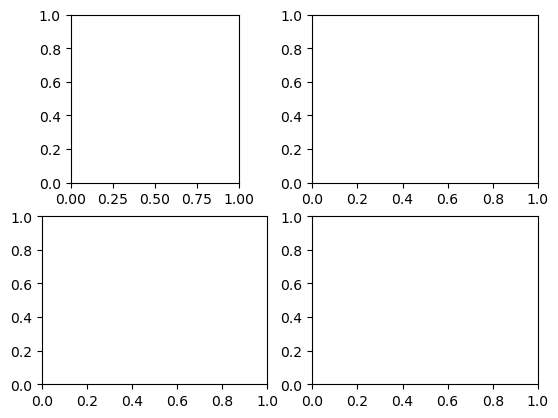

: 

In [4]:
nr = 3

print(np.sum(tel1[0]))
print(np.sum(tel2[0]))
print(np.sum(tel1g[0]))
print(np.sum(tel2g[0]))
print(np.sum(mapped_images[0,nr]))
print(np.sum(mapped_images[1,nr]))
print(np.sum(mapped_images[2,nr]))
print(np.sum(mapped_images[3,nr]))
print(mapped_labels[nr])

plot_image((mapped_images[0,nr],mapped_images[1,nr],mapped_images[2,nr],mapped_images[3,nr]))


In [2]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# If ctapipe >= v0.8.0 is used, please install ctapipe-extra.
from ctapipe.instrument.camera import CameraGeometry

from dl1_data_handler.image_mapper import ImageMapper

In [3]:

# Define the camera types and mapping methods
hex_cams = ['HESS-I']
camera_types = hex_cams
hex_methods = ['oversampling', 'rebinning', 'nearest_interpolation',
               'bilinear_interpolation', 'bicubic_interpolation', 
               'image_shifting', 'axial_addressing']


In [4]:

# Load the image mappers
mappers = {}
print("Initialization time (total for all telescopes):")
for method in hex_methods:
    print(method)
    mapping_method = {cam: method for cam in hex_cams}

    %timeit mappers[method] = ImageMapper(mapping_method=mapping_method,camera_types=["HESS-I"])





Initialization time (total for all telescopes):
oversampling
91.7 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
rebinning
737 ms ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
nearest_interpolation
95.7 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
bilinear_interpolation
353 ms ± 40 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
bicubic_interpolation
2.56 s ± 557 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
image_shifting
37.2 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
axial_addressing
61.6 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
print("Initialization time for individual telescopes (oversampling):")
for cam in camera_types:
    print(cam)
    %timeit ImageMapper(camera_types=[cam])

Initialization time for individual telescopes (oversampling):
HESS-I
96.7 ms ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
def plot_image(image):
    fig, ax = plt.subplots(1)
    ax.set_aspect(1)
    ax.pcolor(image[:,:,0], cmap='viridis')
    plt.show()

HESS-I: Default


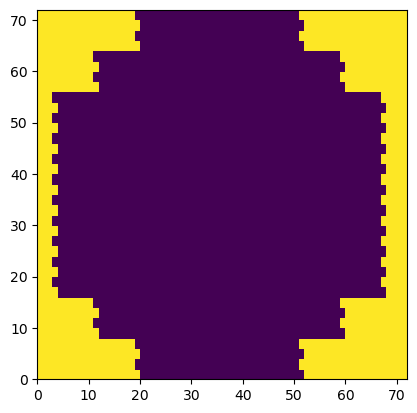

HESS-I: Default


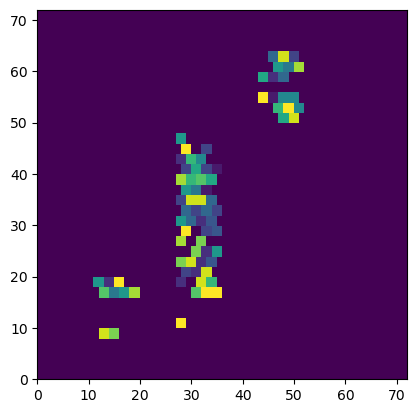

In [25]:
# Generate test pixel values (value is the pixel number)

test_pixel_values = tel1[4]
for cam in camera_types:
    num_pixels = len(CameraGeometry.from_name(cam).pix_id)
    test_pixel_values = np.expand_dims(test_pixel_values, axis=1)

# Plot mapped images with and without padding
default_mapper = ImageMapper(camera_types=['HESS-I'])
#padding_mapper = ImageMapper(padding={cam: 10 for cam in camera_types})

padding_mapper = ImageMapper(padding={cam: 10 for cam in camera_types}, camera_types=["HESS-I"])
#image_shape = default_mapper.map_image(test_pixel_values_1[0], 'HESS-I').shape

for cam in camera_types:
    print('{}: Default'.format(cam))
    image = default_mapper.map_image(test_pixel_values, cam)
    plot_image(image)


test_pixel_values = tel2[4]
for cam in camera_types:
    num_pixels = len(CameraGeometry.from_name(cam).pix_id)
    test_pixel_values = np.expand_dims(test_pixel_values, axis=1)

# Plot mapped images with and without padding
default_mapper = ImageMapper(camera_types=['HESS-I'])
#padding_mapper = ImageMapper(padding={cam: 10 for cam in camera_types})

padding_mapper = ImageMapper(padding={cam: 10 for cam in camera_types}, camera_types=["HESS-I"])
#image_shape = default_mapper.map_image(test_pixel_values_1[0], 'HESS-I').shape

for cam in camera_types:
    print('{}: Default'.format(cam))
    image = default_mapper.map_image(test_pixel_values, cam)
    plot_image(image)


# Checking Images

In [1]:

import tables
import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import random

import fnmatch
import os
#import h5
import glob
import pickle
import sys
import argparse

from ctapipe.io import EventSource
from ctapipe import utils
from ctapipe.instrument.camera import CameraGeometry

from dl1_data_handler.reader import DL1DataReader
from dl1_data_handler.image_mapper import ImageMapper

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential

2023-07-07 16:05:38.920629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_image(image):
    image1, image2, image3, image4 = image
    fig, ax = plt.subplots(2,2)
    ax[0,0].set_aspect(1)
    ax[0,0].pcolor(image1[:,:], cmap='viridis')
    ax[0,1].set_aspect(1)
    ax[0,1].pcolor(image2[:,:], cmap='viridis')
    ax[1,0].set_aspect(1)
    ax[1,0].pcolor(image3[:,:], cmap='viridis')
    ax[1,1].set_aspect(1)
    ax[1,1].pcolor(image4[:,:], cmap='viridis') 
    plt.show()


In [3]:
filePath_gamma="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
filePath_proton="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"



data_p = tables.open_file(filePath_proton, mode="r")
print("Successfully opened proton data!")

# Assigning telescope data to different arrays
tel1p_raw = data_p.get_node('/dl1/event/telescope/images/tel_001').read()
tel2p_raw = data_p.get_node('/dl1/event/telescope/images/tel_002').read()
tel3p_raw = data_p.get_node('/dl1/event/telescope/images/tel_003').read()
tel4p_raw = data_p.get_node('/dl1/event/telescope/images/tel_004').read()

# Reshaping arrays and extracting the data
tel1p = np.stack([data[-1] for data in tel1p_raw])
tel2p = np.stack([data[-1] for data in tel2p_raw])
tel3p = np.stack([data[-1] for data in tel3p_raw])
tel4p = np.stack([data[-1] for data in tel4p_raw])

tel5p_raw = data_p.get_node('/dl1/event/telescope/images/tel_005').read()
tel5p = np.stack([data[-1] for data in tel5p_raw])

labelsp = np.stack([data[2] for data in tel1p_raw])
labelsp_zeros = np.zeros_like(labelsp)

del tel1p_raw
del tel2p_raw
del tel3p_raw
del tel4p_raw

print("Successfully rearranged proton data!")

data_p.close()

Successfully opened proton data!
Successfully rearranged proton data!


In [4]:
# Check Nr 1
ev_nr = 0
print(np.shape(tel1p[ev_nr][:]))
print(tel1p[ev_nr][:])
print(tel2p[ev_nr][:])
print(tel3p[ev_nr][:])
print(tel4p[ev_nr][:])

(960,)
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.

In [5]:
#tel5p_raw = data_p.get_node('/dl1/event/telescope/images/tel_005').read()
#tel5p = np.stack([data[-1] for data in tel5p_raw])

print(np.shape(tel5p_raw))
print(np.shape(tel5p))
print(tel5p[ev_nr][:])

(105704,)
(105704, 1764)
[88. 56. 21. ...  0.  0.  0.]


In [6]:

hex_cams = ['HESS-I']
camera_types = hex_cams 
hex_methods = ['axial_addressing']
#hex_methods = ['oversampling']
#Load the image mappers
mappers = {}
print("Start Initializing Mappers...")
print(os.system("pwd")) 
current_directory = os.getcwd()
print(current_directory)
print("Initialization time (total for all telescopes):")
for method in hex_methods:
    print(method)
    mapping_method = {cam: method for cam in hex_cams}
    mappers[method] = ImageMapper(mapping_method=mapping_method,camera_types=["HESS-I"])
print("... Finished Initializing Mappers")

default_mapper = ImageMapper(camera_types=['HESS-I'])

Start Initializing Mappers...
0
/home/hanneswarnhofer/ECAP_HiWi_WorkingDirectory
Initialization time (total for all telescopes):
axial_addressing
/home/hanneswarnhofer/ECAP_HiWi_WorkingDirectory
... Finished Initializing Mappers


In [7]:
num_events = 1000

# Creating empty arrays for mapped images and the associated labels
mapped_images_1 = np.empty((num_events, 72,72,1))
mapped_images_2 = np.empty((num_events, 72,72,1))
mapped_images_3 = np.empty((num_events, 72,72,1))
mapped_images_4 = np.empty((num_events, 72,72,1))
mapped_labels = np.empty(num_events)

length = num_events
max_value = len(tel1p)
#random_list = random.sample(range(max_value),length) 
random_list = np.random.randint(max_value, size=length)
linear_list = np.linspace(0,num_events-1,num_events,dtype=int)

#print(len(random_list))
#print(len(linear_list))
image_nr = 0
print("Start Mapping...")
for event_nr in linear_list:
    test_pixel_values_1 = np.expand_dims(tel1p[event_nr], axis=1)
    mapped_images_1[image_nr] = default_mapper.map_image(test_pixel_values_1, 'HESS-I')
    test_pixel_values_2 = np.expand_dims(tel2p[event_nr], axis=1)
    mapped_images_2[image_nr] = default_mapper.map_image(test_pixel_values_2, 'HESS-I')
    test_pixel_values_3 = np.expand_dims(tel3p[event_nr], axis=1)
    mapped_images_3[image_nr] = default_mapper.map_image(test_pixel_values_3, 'HESS-I')        
    test_pixel_values_4 = np.expand_dims(tel4p[event_nr], axis=1)
    mapped_images_4[image_nr] = default_mapper.map_image(test_pixel_values_4, 'HESS-I')
    mapped_labels[image_nr] = labelsp[event_nr]
    image_nr=image_nr+1

print("... Finished Mapping")

mapped_images = np.array([mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4])
print(np.shape(mapped_images_1))
print(np.shape(mapped_images))

Start Mapping...
... Finished Mapping
(1000, 72, 72, 1)
(4, 1000, 72, 72, 1)


In [8]:
print(np.shape(mapped_images[0,ev_nr]))
print(np.shape(mapped_images_1[ev_nr]))
#print(mapped_images[0,ev_nr])
#print(mapped_images_1[ev_nr])

(72, 72, 1)
(72, 72, 1)


In [9]:
import matplotlib.pyplot as plt
def plot_image2(image_1,image_2,image_3,image_4,image_nr):
    fig, ax = plt.subplots(2,2)
    ax[0,0].set_aspect(1)
    ax[0,0].pcolor(image_1[image_nr][:,:,0], cmap='viridis')
    ax[0,1].set_aspect(1)
    ax[0,1].pcolor(image_2[image_nr][:,:,0], cmap='viridis')
    ax[1,0].set_aspect(1)
    ax[1,0].pcolor(image_3[image_nr][:,:,0], cmap='viridis')
    ax[1,1].set_aspect(1)
    ax[1,1].pcolor(image_4[image_nr][:,:,0], cmap='viridis')
    plt.show()

    print("Telescope 1: ",np.sum(image_1[image_nr][:,:,0]))
    print("Telescope 2: ",np.sum(image_2[image_nr][:,:,0]))
    print("Telescope 3: ",np.sum(image_3[image_nr][:,:,0]))
    print("Telescope 4: ",np.sum(image_4[image_nr][:,:,0]))

In [10]:
import dl1_data_handler
print(dl1_data_handler.__file__)

/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/dl1_data_handler/__init__.py


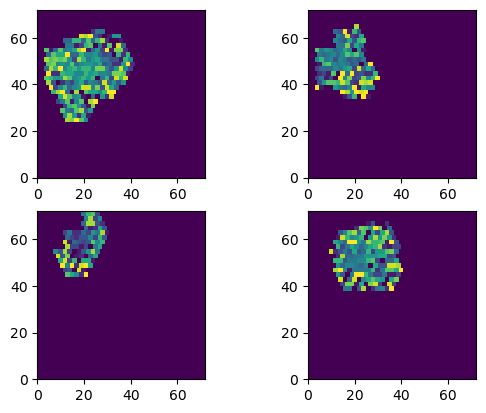

Telescope 1:  1981.0
Telescope 2:  1031.0
Telescope 3:  610.0
Telescope 4:  1313.0


In [14]:
ev_nr = 200

plot_image2(mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4,ev_nr)
#plot_image2(mapped_images[0],mapped_images[1],mapped_images[2],mapped_images[3],ev_nr)

In [12]:
# Reshape the final array, so it is present in the same way as MoDAII data
mapped_images = np.transpose(mapped_images, (1, 0, 2, 3, 4))
mapped_images = np.squeeze(mapped_images, axis=-1)
mapped_labels = mapped_labels[:,np.newaxis]

print(np.shape(mapped_images))
print(np.shape(mapped_labels))

(1000, 4, 72, 72)
(1000, 1)


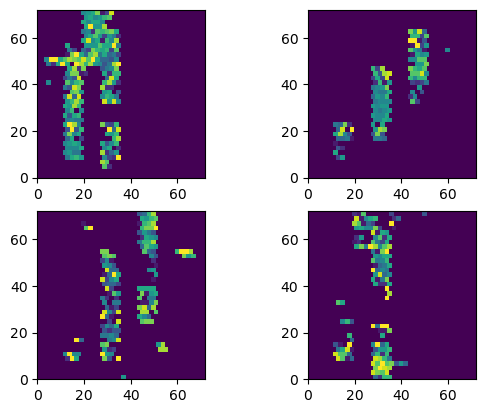

In [47]:

plot_image(mapped_images[ev_nr])

In [48]:
peak_times = mapped_images
event_labels = mapped_labels

# some reshaping for the further use of the timing data in the CNN
peak_times = peak_times.reshape((*np.shape(peak_times),1))

# overview about the important data array for later usage
print(np.shape(peak_times)[0], " events with 4 images each are available \n")
print("Shape of 'event_labels': ",np.shape(event_labels))
print("Shape of 'peak_times': ",np.shape(peak_times),"\n")

# split into random training data (80%) and test data (20%)
train_data, test_data, train_labels, test_labels = [], [], [], []
random_selection = np.random.rand(np.shape(peak_times)[0]) <= 0.8
train_data.append(peak_times[random_selection])
test_data.append(peak_times[~random_selection])
train_labels.append(event_labels[random_selection])
test_labels.append(event_labels[~random_selection])


# free some memory space
del peak_times
del event_labels

# convert to numpy array and reshape 
train_data = np.array(train_data)
train_data = train_data.reshape(np.shape(train_data[0]))
test_data = np.array(test_data)
test_data = test_data.reshape(np.shape(test_data[0]))

train_labels = np.array(train_labels)
train_labels = train_labels.reshape(np.shape(train_labels[0]))
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(np.shape(test_labels[0]))

train_labels_multishape = np.zeros_like(train_data)
test_labels_multishape = np.zeros_like(test_data)

len_train = np.shape(train_data)[0]
len_test = np.shape(test_data)[0]

for i in range(0,len_train):
    train_labels_multishape[i,:,:,:] = train_labels[i]

for k in range(0,len_test):
    test_labels_multishape[k,:,:,:] = test_labels[k]

# overvew about the splitting into training and test data
print("Split into Training and Test Data")
print("Train data shape:", np.shape(train_data) , "-->",round(100*len_train/(len_train+len_test),2),"%")
print("Test data shape:", np.shape(test_data), "-->",round(100*len_test/(len_train+len_test),2), "%")
print("Train labels shape:", np.shape(train_labels))
print("Test labels shape:", np.shape(test_labels))




# split up different "telescopes" for the usage in the seperate single view CNNs (probably in the most long-winded way possible, but lets just ignore that)
train_data_1 = train_data[:,0,:,:] 
train_data_2 = train_data[:,1,:,:] 
train_data_3 = train_data[:,2,:,:] 
train_data_4 = train_data[:,3,:,:] 

test_data_1 = test_data[:,0,:,:]
test_data_2 = test_data[:,1,:,:]
test_data_3 = test_data[:,2,:,:]
test_data_4 = test_data[:,3,:,:]

train_labels_1 = train_labels_multishape[:,0,:,:]
train_labels_2 = train_labels_multishape[:,1,:,:]
train_labels_3 = train_labels_multishape[:,2,:,:]
train_labels_4 = train_labels_multishape[:,3,:,:]

test_labels_1 = test_labels_multishape[:,0,:,:]
test_labels_2 = test_labels_multishape[:,1,:,:]
test_labels_3 = test_labels_multishape[:,2,:,:]
test_labels_4 = test_labels_multishape[:,3,:,:]

print("Train data 1 shape:", np.shape(train_data_1))
print("Train labels 1 shape:", np.shape(train_labels_1))

print("Test data 1 shape:", np.shape(test_data_1))
print("Test labels 1 shape:", np.shape(test_labels_1))

1000  events with 4 images each are available 

Shape of 'event_labels':  (1000, 1)
Shape of 'peak_times':  (1000, 4, 72, 72, 1) 

Split into Training and Test Data
Train data shape: (803, 4, 72, 72, 1) --> 80.3 %
Test data shape: (197, 4, 72, 72, 1) --> 19.7 %
Train labels shape: (803, 1)
Test labels shape: (197, 1)
Train data 1 shape: (803, 72, 72, 1)
Train labels 1 shape: (803, 72, 72, 1)
Test data 1 shape: (197, 72, 72, 1)
Test labels 1 shape: (197, 72, 72, 1)


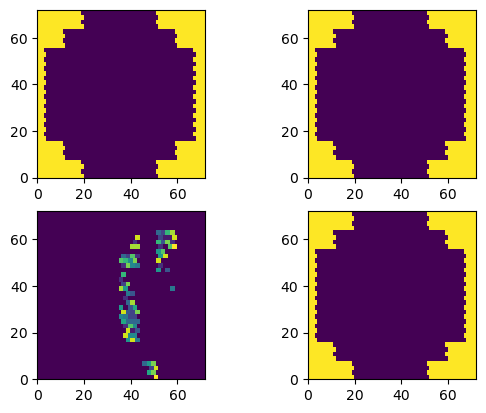

Telescope 1:  -960.0
Telescope 2:  -960.0
Telescope 3:  659.0
Telescope 4:  -960.0


In [51]:
plot_image2(test_data_1,test_data_2,test_data_3,test_data_4,ev_nr)

In [52]:
class MyGenerator(keras.utils.Sequence):

    def __init__(self,images_1,images_2,images_3,images_4,labels,batch_size=64):
        self.batch_size = batch_size
        self.images_1 = images_1
        self.images_2 = images_2
        self.images_3 = images_3
        self.images_4 = images_4
        self.labels = labels
        self.sample_count = len(labels[:])
        self.batch_count = int(self.sample_count/batch_size)
        self.current_batch = 0
        self.index = 0

    def __len__(self):
        return self.batch_count
    
    def __getitem__(self,index):
        
        X = [self.images_1[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:,:,:],self.images_2[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:,:,:],self.images_3[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:,:,:],self.images_4[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:,:,:]]
        y = self.labels[self.current_batch*self.batch_size:(self.current_batch+1)*self.batch_size,:]

        self.current_batch +=1 
        self.data = (X,y)

        return self.data
    
    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= self.sample_count:
            raise StopIteration
        result = self.__getitem__(self.index) 
        self.index += 1
        return result

    def reset_counters(self): 
        self.current_batch = 0 

        
    def on_epoch_end(self):
        self.reset_counters()


In [2]:
import h5py
import numpy as np
from astro_dl_main.data.image_mapper import ImageMapper
#from dl1_data_handler.image_mapper import ImageMapper
import matplotlib.pyplot as plt
#from data import manage
import numpy as np
import os.path
import inspect
import json


class DataManager():
    """ Data class used to manage the HDF5 data files (simulations + Auger data).
        data_path: data_path of HDF5 file, (hint: use blosc compression to ensure adequate decompression speed,
        to mitigate training bottleneck due to a slow data pipeline)
        params:
            data_path = path to HDF5 datset
        optional params:
            stats: data statistics (stats.json - needed for scaling the dataset)
            tasks: list of tasks to be included (default: ['axis', 'core', 'energy', 'xmax'])
            generator_fn: generator function used for looping over data, generator function needs to have indices and
                          shuffle args.
            ad_map_fn: "advanced mapping function" the function used to map the final dataset. Here an additional
                       preprocessing can be implemented which is mapped during training on the
                       cpu (based on tf.data.experimental.map_and_batch)
    """

    def __init__(self, data_path, stats=None, tasks=['axis', 'impact', 'energy', 'classification']):
        ''' init of DataManager class, to manage simulated (CORSIKA/Offline) and measured dataset '''
        np.random.seed(1)
        self.data_path = data_path

    def open_ipython(self):
        from IPython import embed
        embed()

    @property
    def is_data(self):
        return self.type == "Data"

    @property
    def is_mc(self):
        return self.type == "MC"

    def get_h5_file(self):
        return h5py.File(self.data_path, "r")

    def walk_tree(self, details=True):
        """ Draw the tree of yout HDF5 file to see the hierachy of your dataset
            params: detail(activate details to see shapes and used compression ops, Default: True)
        """

        def walk(file, iter_str=''):
            try:
                keys = file.keys()
            except AttributeError:
                keys = []

            for key in keys:
                try:
                    if details:
                        file[key].dtype
                        print(iter_str + str(file[key]))
                    else:
                        print(iter_str + key)
                except AttributeError:
                    print(iter_str + key)
                    walk(file[key], "   " + iter_str)

        with h5py.File(self.data_path, "r") as file:
            print("filename:", file.filename)
            for key in file.keys():
                print(' - ' + key)
                walk(file[key], iter_str='   - ')

    def extract_info(self, path):
        with self.get_h5_file() as f:
            data = f[path]
            y = np.stack(data[:].tolist())

        return {k: y[:, i] for i, k in enumerate(data.dtype.names)}, dict(data.dtype.descr)

    def make_mc_data(self):
        return self.extract_info("simulation/event/subarray/shower")


In [6]:
import tables

path="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
#path = "/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/hess_datasets/phase2d3/phase2d3_proton_20deg_0deg_0.0off.h5"
dm = DataManager(path)
f = dm.get_h5_file()
images = f["dl1/event/telescope/images/tel_002"][0]
#e = tables.open_file(path, mode="r")

for i in range(1, 5):
    print(i)
    #x = e.get_node('/dl1/event/telescope/images/tel_00%i' %i).read()
    x = f["dl1/event/telescope/images/tel_00%i" % i][:]
    print(f["dl1/event/telescope/images/tel_002"])
    
    x = np.stack(np.stack(x.tolist(), axis=0)[:, 3].tolist(), axis=0)
    x = np.stack([data[-1] for data in x])
    m = np.mean(x, axis=-1) > -998
    images = x[m]

    fig, ax = plt.subplots(1, figsize=(11.5, 9))
    ax.hist(images.flatten(), bins=100)
    ax.set_yscale("log")
    ax.set_xlabel("pixel signal CT%i" % i)
    fig.savefig("./pe_intensity_proton_ct%i.png" % i)

plt.close("all")

1
<HDF5 dataset "tel_002": shape (106319,), type "|V7694">


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [7]:
import tables

path="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
#path = "/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/hess_datasets/phase2d3/phase2d3_proton_20deg_0deg_0.0off.h5"
dm = DataManager(path)

f = dm.get_h5_file()
e = tables.open_file(path, mode="r")

x1 = f["dl1/event/telescope/images/tel_001"][:]
x2 = f["dl1/event/telescope/images/tel_002"][:]

y1 = e.get_node('/dl1/event/telescope/images/tel_001').read()
y2 = e.get_node('/dl1/event/telescope/images/tel_002').read()

In [8]:
def make_hess_geometry(file=None):
    # quick fix for dl1 data handler to circumvent to use ctapipe
    if file is None:
        with open(os.path.join(os.getcwd(), "geometry2d3.json")) as f: 
            attr_dict = json.load(f)

        data_ct14 = attr_dict["ct14_geo"]
        data_ct5 = attr_dict["ct5_geo"]
    else:
        data_ct14 = file["configuration/instrument/telescope/camera/geometry_0"][:].tolist()
        data_ct5 = file["configuration/instrument/telescope/camera/geometry_1"][:].tolist()

    class Geometry():
        def __init__(self, data):
            self.pix_id, self.pix_x, self.pix_y, self.pix_area = np.stack(data).T.astype(np.float32)
            self.pos_x = self.pix_x
            self.pos_y = self.pix_y

        def get_pix_pos(self):
            return np.column_stack([self.pix_x, self.pix_y]).T

    return Geometry(data_ct14), Geometry(data_ct5)

def get_current_path():
    filename = inspect.getframeinfo(inspect.currentframe()).filename
    return os.path.dirname(os.path.abspath(filename))

In [9]:

def rotate(pix_pos, rotation_angle=0):
    rotation_angle = rotation_angle * np.pi / 180.0
    rotation_matrix = np.matrix([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                 [np.sin(rotation_angle), np.cos(rotation_angle)], ], dtype=float)

    pixel_positions = np.squeeze(np.asarray(np.dot(rotation_matrix, pix_pos)))
    return pixel_positions

In [10]:
geo_ct14, geo_ct5 = make_hess_geometry()
print(os.getcwd())
ct_14_mapper = ImageMapper(camera_types=["HESS-I"], pixel_positions={"HESS-I": rotate(geo_ct14.get_pix_pos())}, mapping_method={"HESS-I": "axial_addressing"})


/home/hanneswarnhofer/ECAP_HiWi_WorkingDirectory


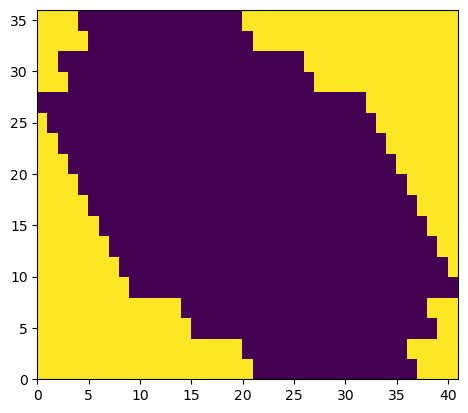

: 

In [20]:
test_img_ct14 = f["dl1/event/telescope/images/tel_001"][50][3][:, np.newaxis]
#test_img_ct5 = f["dl1/event/telescope/images/tel_005"][1][3][:, np.newaxis]

#test_img_ct14 = np.ones(geo_ct14.pix_id.shape)[:, np.newaxis]
#test_img_ct5 = np.ones(geo_ct5.pix_id.shape)[:, np.newaxis]
#test_img_ct14 = np.arange(geo_ct14.pix_id.shape[0])[:, np.newaxis]
#test_img_ct5 = np.arange(geo_ct5.pix_id.shape[0])[:, np.newaxis]


def plot_image(image, name=None):
    fig, ax = plt.subplots(1)
    ax.set_aspect(1)
    ax.pcolor(np.flip(image[:, :, 0], axis=(0)), cmap='viridis', vmin=-5)
    plt.show()
    fig.savefig("./binned_image%s.png" % name)


def re_index_ct14(image):
    return image[5:, :, :]


image_ct14 = ct_14_mapper.map_image(test_img_ct14, "HESS-I")
image_ct14 = re_index_ct14(image_ct14)
plot_image(image_ct14, name="ct14")

In [39]:
#print(x1[0][:,3])
#print(x2[0])

print(x1)
print(x2[0])

print(y1[0])
print(y2[0][3])

[(13275,   32910, 1, [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.000000

In [38]:
#y = np.stack(np.stack(y1.tolist(), axis=0)[3].tolist(), axis=0)
y1list = y1.tolist()
y1stack = np.stack(y1list , axis = 0)
print("Trying:")
print(y1list[:, 3])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [25]:
print(np.shape(x1))
print(np.shape(x2))
print(x1[0][])
x = np.stack(np.stack(x1.tolist(), axis=0)[:, 3].tolist(), axis=0)
x = np.stack(np.stack(x2.tolist(), axis=0)[:, 3].tolist(), axis=0)
print(np.shape(x))

(106319,)
(106319,)
(13275, 32910, 1, [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [1]:

import tables
import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import random

import fnmatch
import os
#import h5
import glob
import pickle
import sys
import argparse
import h5py
import os.path
import inspect
import json

from datetime import datetime
import time

from ctapipe.io import EventSource
from ctapipe import utils
from ctapipe.instrument.camera import CameraGeometry

from dl1_data_handler.reader import DL1DataReader
from dl1_data_handler.image_mapper import ImageMapper

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential

class DataManager():
    """ Data class used to manage the HDF5 data files (simulations + Auger data).
        data_path: data_path of HDF5 file, (hint: use blosc compression to ensure adequate decompression speed,
        to mitigate training bottleneck due to a slow data pipeline)
        params:
            data_path = path to HDF5 datset
        optional params:
            stats: data statistics (stats.json - needed for scaling the dataset)
            tasks: list of tasks to be included (default: ['axis', 'core', 'energy', 'xmax'])
            generator_fn: generator function used for looping over data, generator function needs to have indices and
                          shuffle args.
            ad_map_fn: "advanced mapping function" the function used to map the final dataset. Here an additional
                       preprocessing can be implemented which is mapped during training on the
                       cpu (based on tf.data.experimental.map_and_batch)
    """

    def __init__(self, data_path, stats=None, tasks=['axis', 'impact', 'energy', 'classification']):
        ''' init of DataManager class, to manage simulated (CORSIKA/Offline) and measured dataset '''
        current_timestamp = int(time.time())
        np.random.seed(current_timestamp)
        self.data_path = data_path

    def open_ipython(self):
        from IPython import embed
        embed()

    @property
    def is_data(self):
        return self.type == "Data"

    @property
    def is_mc(self):
        return self.type == "MC"

    def get_h5_file(self):
        return h5py.File(self.data_path, "r")

    def walk_tree(self, details=True):
        """ Draw the tree of yout HDF5 file to see the hierachy of your dataset
            params: detail(activate details to see shapes and used compression ops, Default: True)
        """

        def walk(file, iter_str=''):
            try:
                keys = file.keys()
            except AttributeError:
                keys = []

            for key in keys:
                try:
                    if details:
                        file[key].dtype
                        print(iter_str + str(file[key]))
                    else:
                        print(iter_str + key)
                except AttributeError:
                    print(iter_str + key)
                    walk(file[key], "   " + iter_str)

        with h5py.File(self.data_path, "r") as file:
            print("filename:", file.filename)
            for key in file.keys():
                print(' - ' + key)
                walk(file[key], iter_str='   - ')

    def extract_info(self, path):
        with self.get_h5_file() as f:
            data = f[path]
            y = np.stack(data[:].tolist())

        return {k: y[:, i] for i, k in enumerate(data.dtype.names)}, dict(data.dtype.descr)

    def make_mc_data(self):
        return self.extract_info("simulation/event/subarray/shower")

class MyGenerator(keras.utils.Sequence):

    def __init__(self,images_1,images_2,images_3,images_4,labels,batch_size):
        self.batch_size = batch_size
        self.images_1 = images_1
        self.images_2 = images_2
        self.images_3 = images_3
        self.images_4 = images_4
        self.labels = labels
        self.sample_count = len(labels[:])
        self.batch_count = int(self.sample_count/self.batch_size)
        self.current_batch = 0
        self.index = 0

    def __len__(self):
        return self.batch_count



    def __getitem__(self,index):
        idx_low  = self.current_batch*self.batch_size
        idx_high = (self.current_batch+1)*self.batch_size
        X = np.array([self.images_1[idx_low:idx_high],self.images_2[idx_low:idx_high],self.images_3[idx_low:idx_high],self.images_4[idx_low:idx_high]])
        y = np.array(self.labels[idx_low:idx_high])

        self.current_batch +=1 
        self.data = (X,y)

        return self.data
        
    ''' 

    def __getitem__(self,index):
        idx_low  = self.current_batch*self.batch_size
        idx_high = (self.current_batch+1)*self.batch_size
        images_batch_1 = self.images_1[idx_low:idx_high]
        images_batch_2 = self.images_2[idx_low:idx_high]
        images_batch_3 = self.images_3[idx_low:idx_high]
        images_batch_4 = self.images_4[idx_low:idx_high]

        labels_batch = np.array(self.labels[idx_low:idx_high])

        # Assuming your images are of shape (41, 41, 1)
        images_batch_1 = np.expand_dims(images_batch_1, axis=-1)
        images_batch_2 = np.expand_dims(images_batch_2, axis=-1)
        images_batch_3 = np.expand_dims(images_batch_3, axis=-1)
        images_batch_4 = np.expand_dims(images_batch_4, axis=-1)

        self.current_batch +=1 
        self.data = (np.array([images_batch_1, images_batch_2, images_batch_3, images_batch_4]), labels_batch)

        # MAYBE CHECK: X = np.array([...]) and y = labels_batch

        return self.data
    '''
    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= self.sample_count:
            raise StopIteration
        result = self.__getitem__(self.index) 
        self.index += 1
        return result

    def plot_batch(self, event_nr=100):
        print(np.shape(self.images_1))
        print(np.shape(self.images_1[event_nr]))
        image_batch_1 = self.images_1
        image_batch_2 = self.images_2
        image_batch_3 = self.images_3
        image_batch_4 = self.images_4
        label_batch = self.labels
        plot_image_2by2(image_batch_1,image_batch_2,image_batch_3,image_batch_4, labels=label_batch, event_nr=event_nr,string="generator")

    def __shape__(self):
        print("Shape of self.images1: ",np.shape(self.images_1))
        print("Shape of first event: ",np.shape(self.images_1[0]))

    def reset_counters(self): 
        self.current_batch = 0 

        
    def on_epoch_end(self):
        self.reset_counters()

class OnEpochBegin(keras.callbacks.Callback): # Callback class called on epoch begin to reset counters
    def on_epoch_begin(self, epoch, logs=None):
        training_generator.reset_counters()
        testing_generator.reset_counters()
        print("Epoch Begin")


def re_index_ct14(image):
    return image[5:, :, :]

def make_hess_geometry(file=None):
    # quick fix for dl1 data handler to circumvent to use ctapipe
    if file is None:
        with open(os.path.join(os.getcwd(), "geometry2d3.json")) as f: 
            attr_dict = json.load(f)

        data_ct14 = attr_dict["ct14_geo"]
        data_ct5 = attr_dict["ct5_geo"]
    else:
        data_ct14 = file["configuration/instrument/telescope/camera/geometry_0"][:].tolist()
        data_ct5 = file["configuration/instrument/telescope/camera/geometry_1"][:].tolist()

    class Geometry():
        def __init__(self, data):
            self.pix_id, self.pix_x, self.pix_y, self.pix_area = np.stack(data).T.astype(np.float32)
            self.pos_x = self.pix_x
            self.pos_y = self.pix_y

        def get_pix_pos(self):
            return np.column_stack([self.pix_x, self.pix_y]).T

    return Geometry(data_ct14), Geometry(data_ct5)

def get_current_path():
    filename = inspect.getframeinfo(inspect.currentframe()).filename
    return os.path.dirname(os.path.abspath(filename))

def rotate(pix_pos, rotation_angle=0):
    rotation_angle = rotation_angle * np.pi / 180.0
    rotation_matrix = np.matrix([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                [np.sin(rotation_angle), np.cos(rotation_angle)], ], dtype=float)

    pixel_positions = np.squeeze(np.asarray(np.dot(rotation_matrix, pix_pos)))
    return pixel_positions

def plot_image_2by2(train_data,event_nr,labels,string,dt):

    

    

    print("Plotting Example Event. Event Nr: ", event_nr)

    image1 = train_data[:,0,:,:] 
    image2 = train_data[:,1,:,:] 
    image3 = train_data[:,2,:,:] 
    image4 = train_data[:,3,:,:] 

    pltimage1 = image1[event_nr]
    pltimage2 = image2[event_nr]
    pltimage3 = image3[event_nr]
    pltimage4 = image4[event_nr]

    fig, ax = plt.subplots(2,2)

    im1 = ax[0,0].imshow(pltimage1[:,:,0], cmap='viridis',vmin=0)
    im2 = ax[0,1].imshow(pltimage2[:,:,0], cmap='viridis',vmin=0)
    im3 = ax[1,0].imshow(pltimage3[:,:,0], cmap='viridis',vmin=0)
    im4 = ax[1,1].imshow(pltimage4[:,:,0], cmap='viridis',vmin=0)

    cbar1 = fig.colorbar(im1, ax=ax[0, 0], orientation='vertical')
    cbar2 = fig.colorbar(im2, ax=ax[0, 1], orientation='vertical')
    cbar3 = fig.colorbar(im3, ax=ax[1, 0], orientation='vertical')
    cbar4 = fig.colorbar(im4, ax=ax[1, 1], orientation='vertical')


    label1 = labels[event_nr].ravel()[0]
    label2 = labels[event_nr].ravel()[1]
    label3 = labels[event_nr].ravel()[2]
    label4 = labels[event_nr].ravel()[3]

    str_label1 = '{}'.format(label1)
    str_label2 = '{}'.format(label2)
    str_label3 = '{}'.format(label3)
    str_label4 = '{}'.format(label4)

    ax[0, 0].text(0.05, 0.95, str_label1, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[0, 1].text(0.05, 0.95, str_label2, transform=ax[0, 1].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 0].text(0.05, 0.95, str_label3, transform=ax[1, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 1].text(0.05, 0.95, str_label4, transform=ax[1, 1].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    #plt.show()

    print("Min. and Max. Value for Image 1: ", np.min(pltimage1), " - " , np.max(pltimage1) , ". Sum: ", np.sum(pltimage1))
    print("Min. and Max. Value for Image 2: ", np.min(pltimage2), " - " , np.max(pltimage2), ". Sum: ", np.sum(pltimage2))
    print("Min. and Max. Value for Image 3: ", np.min(pltimage3), " - " , np.max(pltimage3), ". Sum: ", np.sum(pltimage3))
    print("Min. and Max. Value for Image 4: ", np.min(pltimage4), " - " , np.max(pltimage4), ". Sum: ", np.sum(pltimage4))


    str_evnr = '{}'.format(event_nr)
    name = "Test_images/Test_figure_evnr_" + str_evnr + "_" + string + "_" + dt + ".png"
    fig.savefig(name)

print("Functions Defined.")

'''
parser = argparse.ArgumentParser()
parser.add_argument("-e", "--epochs", type=int)
parser.add_argument("-b", "--batch_size", type=int)
parser.add_argument("-r", "--rate", type=float)
parser.add_argument("-reg", "--regulization", type=float)
parser.add_argument("-t", "--threshold", type=float)
parser.add_argument("-c", "--cut", type=int)
parser.add_argument("-ne", "--numevents", type=int)

args = parser.parse_args()
num_epochs = args.epochs
batch_size = args.batch_size
rate = args.rate
reg = args.regulization
sum_threshold = args.threshold
cut_nonzero = args.cut
num_events = args.numevents
'''
# Define the appendix to the file, for being able to specify some general changes in the model structure and trace back the changes when comparing the results of t´different models
fnr = "ResNet50" 

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M")
print("Date-Time: ", formatted_datetime)

num_events = 100
amount = int(num_events * 2)
filePath_gamma="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
#filePath_gamma = "../../../../wecapstor1/caph/mppi111h/old_dataset/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
#filePath_gamma = "../../../../wecapstor1/caph/mppi111h/new_sims/dnn/gamma_diffuse_noZBDT_noLocDist_hybrid_v2.h5"

filePath_proton="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"
#filePath_proton = "../../../../wecapstor1/caph/mppi111h/old_dataset/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"
#filePath_proton="../../../../wecapstor1/caph/mppi111h/new_sims/dnn/proton_noZBDT_noLocDist_hybrid_v2.h5"

dm_gamma = DataManager(filePath_gamma)
f_g = dm_gamma.get_h5_file()

if num_events >= len(f_g["dl1/event/telescope/images/tel_001"][:]) : num_events = len(f_g["dl1/event/telescope/images/tel_001"][:]) - 2
if amount >= len(f_g["dl1/event/telescope/images/tel_001"][:]) : amount = len(f_g["dl1/event/telescope/images/tel_001"][:]) - 1

tel1g_raw = f_g["dl1/event/telescope/images/tel_001"][0:amount]
tel2g_raw = f_g["dl1/event/telescope/images/tel_002"][0:amount]
tel3g_raw = f_g["dl1/event/telescope/images/tel_003"][0:amount]
tel4g_raw = f_g["dl1/event/telescope/images/tel_004"][0:amount]
#tel5g_raw = f_g["dl1/event/telescope/images/tel_005"][0:amount]

print("Successfully opened gamma data!")

labelsg = np.stack([data[2] for data in tel1g_raw])
labelsg_ones = np.ones_like(labelsg)

f_g.close()

dm_proton = DataManager(filePath_proton)
f_p = dm_proton.get_h5_file()

tel1p_raw = f_p["dl1/event/telescope/images/tel_001"][0:amount]
tel2p_raw = f_p["dl1/event/telescope/images/tel_002"][0:amount]
tel3p_raw = f_p["dl1/event/telescope/images/tel_003"][0:amount]
tel4p_raw = f_p["dl1/event/telescope/images/tel_004"][0:amount]
#tel5p_raw = f_p["dl1/event/telescope/images/tel_005"][0:amount]

print("Successfully opened proton data!")

labelsp = np.stack([data[2] for data in tel1p_raw])
labelsp_zeros = np.zeros_like(labelsp)

tel1 = np.concatenate((tel1g_raw,tel1p_raw),axis=0)
tel2 = np.concatenate((tel2g_raw,tel2p_raw),axis=0)
tel3 = np.concatenate((tel3g_raw,tel3p_raw),axis=0)
tel4 = np.concatenate((tel4g_raw,tel4p_raw),axis=0)
#tel5 = np.concatenate((tel5g_raw,tel5p_raw),axis=0)
labels = np.concatenate((labelsg_ones,labelsp_zeros),axis=0)

del tel1g_raw
del tel2g_raw
del tel3g_raw
del tel4g_raw

del tel1p_raw
del tel2p_raw
del tel3p_raw
del tel4p_raw

f_p.close()

del labelsp
del labelsg
del labelsp_zeros
del labelsg_ones

print("Shape of Tel1: ",np.shape(tel1))
print("Shape of Tel2: ",np.shape(tel2))
print("Shape of Tel3: ",np.shape(tel3))
print("Shape of Tel4: ",np.shape(tel4))
#print("Shape of Tel5: ",np.shape(tel5))
print("Shape of Labels: ",np.shape(labels))
print("Labels: ",labels)

geo_ct14, geo_ct5 = make_hess_geometry()
print(os.getcwd())
ct_14_mapper = ImageMapper(camera_types=["HESS-I"], pixel_positions={"HESS-I": rotate(geo_ct14.get_pix_pos())}, mapping_method={"HESS-I": "axial_addressing"})
#ct_5_mapper = ImageMapper(camera_types=["HESS-II"], pixel_positions={"HESS-II": rotate(geo_ct5.get_pix_pos())}, mapping_method={"HESS-II": "axial_addressing"})

mapped_images_1 = np.empty((num_events, 41,41,1))
mapped_images_2 = np.empty((num_events, 41,41,1))
mapped_images_3 = np.empty((num_events, 41,41,1))
mapped_images_4 = np.empty((num_events, 41,41,1))
#mapped_images_4 = np.empty((num_events, 41,41,1))
mapped_labels = np.empty(num_events)

length = num_events
max_value = len(tel1)
random_list = np.random.randint(max_value, size=length)
image_nr = 0

print(random_list[0:10])

cut_nonzero = 2
threshold_value = 0.0001  # Adjust this threshold value as needed

print("Start Mapping...")
for event_nr in random_list:


    
    image_1 = ct_14_mapper.map_image(tel1[event_nr][3][:, np.newaxis], 'HESS-I')
    image_2 = ct_14_mapper.map_image(tel2[event_nr][3][:, np.newaxis], 'HESS-I')
    image_3 = ct_14_mapper.map_image(tel3[event_nr][3][:, np.newaxis], 'HESS-I')   
    image_4 = ct_14_mapper.map_image(tel4[event_nr][3][:, np.newaxis], 'HESS-I')
    #image_5 = ct_5_mapper.map_image(tel5[event_nr][3][:, np.newaxis], 'HESS-II')   

    # Apply threshold on the sum of pixel values
    #sum_threshold = 60  # Adjust this value to your desired threshold
    sum_threshold = 60 #args.threshold

    if np.sum(image_1) < sum_threshold:
        image_1[:] = 0
    if np.sum(image_2) < sum_threshold:
        image_2[:] = 0
    if np.sum(image_3) < sum_threshold:
        image_3[:] = 0
    if np.sum(image_4) < sum_threshold:
        image_4[:] = 0
     
    # Set all pixels lower than the threshold value to zero
    image_1[image_1 < threshold_value] = 0
    image_2[image_2 < threshold_value] = 0
    image_3[image_3 < threshold_value] = 0
    image_4[image_4 < threshold_value] = 0
    #image_5[image_5 < threshold_value] = 0

    non_zero_count = sum(1 for img in [image_1, image_2, image_3, image_4] if np.sum(img) > 0)
    if non_zero_count >= cut_nonzero:
        mapped_images_1[image_nr] = image_1
        mapped_images_2[image_nr] = image_2
        mapped_images_3[image_nr] = image_3
        mapped_images_4[image_nr] = image_4
        #mapped_images_5[image_nr] = image_5
        mapped_labels[image_nr] = labels[event_nr]
        image_nr += 1
    
print("... Finished Mapping")

'''
print("Start Mapping...")
for event_nr in random_list:
    mapped_images_1[image_nr] = ct_14_mapper.map_image(tel1[event_nr][3][:, np.newaxis], 'HESS-I')
    mapped_images_2[image_nr] = ct_14_mapper.map_image(tel2[event_nr][3][:, np.newaxis], 'HESS-I')
    mapped_images_3[image_nr] = ct_14_mapper.map_image(tel3[event_nr][3][:, np.newaxis], 'HESS-I')   
    mapped_images_4[image_nr] = ct_14_mapper.map_image(tel4[event_nr][3][:, np.newaxis], 'HESS-I')
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1
print("... Finished Mapping")
'''
#########################################   MAYBE TRY CONVERTING ALL "EMPTY" IMAGES IN SUCH A WAY
#########################################   THAT ALL PIXELS BECOME ZERO? IF SUM < 0 -> ALL_PIXELS=0
#########################################   


mapped_images = np.array([mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4]) #mapped_images_5])
print("Shape of mapped_images_1: ",np.shape(mapped_images_1))
print("Shape of mapped_images: ",np.shape(mapped_images))

del tel1
del tel2
del tel3
del tel4
del labels

del mapped_images_1
del mapped_images_2
del mapped_images_3
del mapped_images_4

# Reshape the final array, so it is present in the same way as MoDAII data
mapped_images = np.transpose(mapped_images, (1, 0, 2, 3, 4))
mapped_images = np.squeeze(mapped_images, axis=-1)
mapped_labels = mapped_labels[:,np.newaxis]

print("New shape of mapped_images: ",np.shape(mapped_images))
print("New shape of mapped_labels: ",np.shape(mapped_labels))


########################################################
# START WITH CNN STUFF


patience = 5
input_shape = (41, 41, 1)
#input_shape5 = (72,72,1)
pool_size = 2
kernel_size = 2

# some reshaping for the further use of the timing data in the CNN
mapped_images = mapped_images.reshape((*np.shape(mapped_images),1))

# overview about the important data array for later usage
print(np.shape(mapped_images)[0], " events with 4 images each are available \n")
print("Shape of 'event_labels': ",np.shape(mapped_labels))
print("Shape of 'peak_times': ",np.shape(mapped_images),"\n")

# split into random training data (80%) and test data (20%)
train_data = []
test_data = []
train_labels = []
test_labels = [] 

#data_dummy = mapped_images

random_selection = np.random.rand(np.shape(mapped_images)[0]) <= 0.8


train_data.append(mapped_images[random_selection])
test_data.append(mapped_images[~random_selection])
train_labels.append(mapped_labels[random_selection])
test_labels.append(mapped_labels[~random_selection])

#mapped_images = data_dummy
#del data_dummy

print(random_selection[0:10])

# free some memory space
del mapped_images
del mapped_labels

# convert to numpy array and reshape 
train_data = np.array(train_data)
train_data = train_data.reshape(np.shape(train_data[0]))
test_data = np.array(test_data)
test_data = test_data.reshape(np.shape(test_data[0]))

train_labels = np.array(train_labels)
train_labels = train_labels.reshape(np.shape(train_labels[0]))
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(np.shape(test_labels[0]))

train_labels_multishape = np.zeros_like(train_data)
test_labels_multishape = np.zeros_like(test_data)

len_train = np.shape(train_data)[0]
len_test = np.shape(test_data)[0]

for i in range(0,len_train):
    train_labels_multishape[i,:,:,:] = train_labels[i]

for k in range(0,len_test):
    test_labels_multishape[k,:,:,:] = test_labels[k]

# overvew about the splitting into training and test data
print("Split into Training and Test Data")
print("Train data shape:", np.shape(train_data) , "-->",round(100*len_train/(len_train+len_test),2),"%")
print("Test data shape:", np.shape(test_data), "-->",round(100*len_test/(len_train+len_test),2), "%")
print("Train labels shape:", np.shape(train_labels))
print("Test labels shape:", np.shape(test_labels))

# split up different "telescopes" for the usage in the seperate single view CNNs (probably in the most long-winded way possible, but lets just ignore that)
train_data_1 = train_data[:,0,:,:] 
train_data_2 = train_data[:,1,:,:] 
train_data_3 = train_data[:,2,:,:] 
train_data_4 = train_data[:,3,:,:] 
#train_data_5 = train_data[:,4,:,:] 

test_data_1 = test_data[:,0,:,:]
test_data_2 = test_data[:,1,:,:]
test_data_3 = test_data[:,2,:,:]
test_data_4 = test_data[:,3,:,:]
#test_data_5 = test_data[:,4,:,:]

train_labels_1 = train_labels_multishape[:,0,:,:]
train_labels_2 = train_labels_multishape[:,1,:,:]
train_labels_3 = train_labels_multishape[:,2,:,:]
train_labels_4 = train_labels_multishape[:,3,:,:]
#train_labels_5 = train_labels_multishape[:,4,:,:]

test_labels_1 = test_labels_multishape[:,0,:,:]
test_labels_2 = test_labels_multishape[:,1,:,:]
test_labels_3 = test_labels_multishape[:,2,:,:]
test_labels_4 = test_labels_multishape[:,3,:,:]
#test_labels_5 = test_labels_multishape[:,4,:,:]

print("Train data 1 shape:", np.shape(train_data_1))
print("Train labels 1 shape:", np.shape(train_labels_1))

print("Test data 1 shape:", np.shape(test_data_1))
print("Test labels 1 shape:", np.shape(test_labels_1))



print("Test data 1:",test_data_1)

2023-10-16 11:11:39.985989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Functions Defined.
Date-Time:  2023-10-16_11-11
Successfully opened gamma data!
Successfully opened proton data!
Shape of Tel1:  (400,)
Shape of Tel2:  (400,)
Shape of Tel3:  (400,)
Shape of Tel4:  (400,)
Shape of Labels:  (400,)
Labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

In [24]:
def convert_to_rgb(image):
    # Expand single-channel image to three channels
    return np.stack([image]*3, axis=-1).squeeze()

def custom_preprocess_input(x):
    # Perform custom preprocessing (e.g., scaling)
    max_val = np.max(x)
    if max_val != 0:
        x = x / np.max(x)  # Scale pixel values to the range [0, 1]
    return x

pp_test_data_1 = preprocess_input(convert_to_rgb(test_data_1.reshape(test_data_1.shape[:-1])))
cpp_test_data_1 = custom_preprocess_input(test_data_1)

print(np.shape(test_data_1))
print(np.shape(pp_test_data_1))
print(np.shape(cpp_test_data_1))
print(pp_test_data_1)
print(cpp_test_data_1)

(14, 41, 41, 1)
(14, 41, 41, 3)
(14, 41, 41, 1)
[[[[-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   ...
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]]

  [[-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   ...
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]]

  [[-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   ...
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.16779000e+02 -1.23680000e+02]
   [-1.03939000e+02 -1.167

In [78]:
rate = 0.0001
reg = 0.00005
#Define the model for the single-view CNNs
def create_cnn_model(input_shape):
    input_layer = Input(shape=input_shape)
    #x = Conv2D(3, (1, 1))(input_layer)
    #preprocessed_input = preprocess_input(x)
    #print(preprocessed_input)
    #i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    #x = tf.cast(i, tf.float32)
    #x = tf.keras.applications.mobilenet.preprocess_input(x)
    #core = tf.keras.applications.MobileNet()
    #x = core(x)
    #model = tf.keras.Model(inputs=[i], outputs=[x])

    #image = tf.image.decode_png(tf.io.read_file('file.png'))
    #result = model(image)
    Seq_model = Sequential()(input_layer)
    #ResNet50_model = ResNet50(include_top=False, weights=None, input_tensor=input_layer)



    Conv1 = Conv2D(filters=200, kernel_size=kernel_size, padding='same',kernel_regularizer=regularizers.l2(reg), input_shape=input_shape,)(Seq_model)
    LeakyRelu1 = LeakyReLU(alpha=0.1)(Conv1)
    MaxPool1 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu1)

    #print("Before first Dropout")

    Dropout1 = Dropout(rate)(MaxPool1)
    Conv2 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout1)
    LeakyRelu2 = LeakyReLU(alpha=0.1)(Conv2) 
    MaxPool2 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu2)

    Dropout2 = Dropout(rate)(MaxPool2)
    Conv3 = Conv2D(filters=50, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout2)
    LeakyRelu3 = LeakyReLU(alpha=0.1)(Conv3) 
    MaxPool3 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu3)

    Dropout3 = Dropout(rate)(MaxPool3)
    Conv4 = Conv2D(filters=50, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout3)
    LeakyRelu4 = LeakyReLU(alpha=0.1)(Conv4) 
    MaxPool4 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu4)

    Dropout4 = Dropout(rate)(MaxPool4)
    Conv5 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout4)
    LeakyRelu5 = LeakyReLU(alpha=0.1)(Conv5) 
    MaxPool5 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu5)

    Dropout5 = Dropout(rate)(MaxPool5)
    Conv6 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout5)
    MaxPool6 = MaxPooling2D(pool_size=pool_size, padding='same')(Conv6)

    Dropout6 = Dropout(rate)(MaxPool6)
    Conv7 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout6)
    MaxPool7 = MaxPooling2D(pool_size=pool_size, padding='same')(Conv7)

    model = Model(inputs=input_layer, outputs=MaxPool7)
    return model

# Define the model for the combination of the previous CNNs and the final CNN for classification

def run_multiview_model(models,inputs):

    merged = concatenate(models)

    Dropout1 = Dropout(rate)(merged)
    Conv_merged1 = Conv2D(filters=100,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout1)
    MaxPool_merged1 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged1)

    Dropout2 = Dropout(rate)(MaxPool_merged1)
    Conv_merged2 = Conv2D(filters=50,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout2)
    MaxPool_merged2 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged2)

    Dropout3 = Dropout(rate)(MaxPool_merged2)
    Conv_merged3 = Conv2D(filters=80,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout3)
    MaxPool_merged3 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged3)

    Dropout31 = Dropout(rate)(MaxPool_merged3)
    Conv_merged31 = Conv2D(filters=140,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout31)
    MaxPool_merged31 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged31)

    Flat_merged1 = Flatten()(MaxPool_merged31)
    Dropout4 = Dropout(rate)(Flat_merged1)
    dense_layer_merged1 = Dense(units=100, activation='relu')(Dropout4)

    Dropout6 = Dropout(rate)(dense_layer_merged1)
    dense_layer_merged3 = Dense(units=1, activation='sigmoid')(Dropout6)

    model = Model(inputs=inputs, outputs=dense_layer_merged3)
    return model

# Create four separate CNN models
input_1 = Input(shape=input_shape)

cnn_model_1 = create_cnn_model(input_shape)(input_1)

input_2 = Input(shape=input_shape)
cnn_model_2 = create_cnn_model(input_shape)(input_2)

input_3 = Input(shape=input_shape)
cnn_model_3 = create_cnn_model(input_shape)(input_3)

input_4 = Input(shape=input_shape)
cnn_model_4 = create_cnn_model(input_shape)(input_4)



# include early_stopping here, to see how it changes compared to previous model designs
#early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

model_multi = run_multiview_model([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4])
model_multi.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 41, 41, 1)]  0           []                               
                                                                                            

In [79]:


early_stopping_callback_1=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,verbose=1,mode='min')
from keras.losses import BinaryCrossentropy

# Create the loss function with from_logits=True
loss_fn = BinaryCrossentropy(from_logits=True)

# Compile the model using the created loss function
model_multi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Starting the Fitting ...")
num_epochs = 5
batch_size = 4


cpp_test_data_1 = custom_preprocess_input(test_data_1)
cpp_test_data_2 = custom_preprocess_input(test_data_2)
cpp_test_data_3 = custom_preprocess_input(test_data_3)
cpp_test_data_4 = custom_preprocess_input(test_data_4)

cpp_train_data_1 = custom_preprocess_input(train_data_1)
cpp_train_data_2 = custom_preprocess_input(train_data_2)
cpp_train_data_3 = custom_preprocess_input(train_data_3)
cpp_train_data_4 = custom_preprocess_input(train_data_4)


pp_test_data_1 = preprocess_input(convert_to_rgb(test_data_1.reshape(test_data_1.shape[:-1])))
pp_test_data_2 = preprocess_input(convert_to_rgb(test_data_2.reshape(test_data_2.shape[:-1])))
pp_test_data_3 = preprocess_input(convert_to_rgb(test_data_3.reshape(test_data_3.shape[:-1])))
pp_test_data_4 = preprocess_input(convert_to_rgb(test_data_4.reshape(test_data_4.shape[:-1])))

pp_train_data_1 = preprocess_input(convert_to_rgb(train_data_1.reshape(train_data_1.shape[:-1])))
pp_train_data_2 = preprocess_input(convert_to_rgb(train_data_2.reshape(train_data_2.shape[:-1])))
pp_train_data_3 = preprocess_input(convert_to_rgb(train_data_3.reshape(train_data_3.shape[:-1])))
pp_train_data_4 = preprocess_input(convert_to_rgb(train_data_4.reshape(train_data_4.shape[:-1])))


#pp_train_data[:,0,:,:]=pp_train_data_1

#plot_image_2by2([cpp_train_data_1,cpp_train_data_2,cpp_train_data_3,cpp_train_data_4],4,train_labels_multishape,string="cpptrain",dt=formatted_datetime)
#plot_image_2by2([pp_train_data_1,pp_train_data_2,pp_train_data_3,pp_train_data_4],4,train_labels_multishape,string="pptrain",dt=formatted_datetime)

print("Max:",np.max(train_data_1))
print("Max_pp:",np.max(pp_train_data_1))
print("Max_cpp:",np.max(cpp_train_data_1))
#print("train_data_1:",train_data_1)
#print("pp_train_data_1:",pp_train_data_1)

#history = model_multi.fit([cpp_train_data_1,cpp_train_data_2,cpp_train_data_3,cpp_train_data_4],train_labels,epochs=num_epochs,batch_size=batch_size,validation_data=([cpp_test_data_1,cpp_test_data_2,cpp_test_data_3,cpp_test_data_4], test_labels), callbacks=[early_stopping_callback_1])


#history = model_multi.fit(training_generator, epochs=num_epochs, batch_size= batch_size,validation_data=testing_generator, callbacks=[early_stopping_callback_1])
#history = model_multi.fit([custom_preprocess_input(train_data[:,i,:,:] for i in range(4))],train_labels,epochs=num_epochs,batch_size=batch_size,validation_data=([custom_preprocess_input(test_data[:,i,:,:] for i in range(4))], test_labels), callbacks=[early_stopping_callback_1])


Starting the Fitting ...
Max: 1.2779291919060354e+308
Max_pp: 1.2779291919060354e+308
Max_cpp: 1.0


/tmp/ipykernel_15695/2507639955.py:14: RuntimeWarning: overflow encountered in divide
  normalized_data[event] = data[event]/max_value


In [27]:
cpp_train_data = np.zeros_like(train_data)
cpp_train_data[:,0,:,:]=cpp_train_data_1
cpp_train_data[:,1,:,:]=cpp_train_data_2
cpp_train_data[:,2,:,:]=cpp_train_data_3
cpp_train_data[:,3,:,:]=cpp_train_data_4

pp_train_data = np.zeros_like(convert_to_rgb(train_data.reshape(train_data.shape[:-1])))
pp_train_data[:,0,:,:]=pp_train_data_1
pp_train_data[:,1,:,:]=pp_train_data_2
pp_train_data[:,2,:,:]=pp_train_data_3
pp_train_data[:,3,:,:]=pp_train_data_4

plot_image_2by2([cpp_train_data_1,cpp_train_data_2,cpp_train_data_3,cpp_train_data_4],4,train_labels_multishape,string="cpptrain",dt=formatted_datetime)
plot_image_2by2([pp_train_data_1,pp_train_data_2,pp_train_data_3,pp_train_data_4],4,train_labels_multishape,string="pptrain",dt=formatted_datetime)


Plotting Example Event. Event Nr:  4


TypeError: list indices must be integers or slices, not tuple

In [16]:
def plot_image_2by2_v2(image1,image2,image3,image4,event_nr,labels,string,dt):

    

    

    print("Plotting Example Event. Event Nr: ", event_nr)


    pltimage1 = image1[event_nr]
    pltimage2 = image2[event_nr]
    pltimage3 = image3[event_nr]
    pltimage4 = image4[event_nr]

    fig, ax = plt.subplots(2,2)

    im1 = ax[0,0].imshow(pltimage1[:,:,0], cmap='viridis',vmin=0)
    im2 = ax[0,1].imshow(pltimage2[:,:,0], cmap='viridis',vmin=0)
    im3 = ax[1,0].imshow(pltimage3[:,:,0], cmap='viridis',vmin=0)
    im4 = ax[1,1].imshow(pltimage4[:,:,0], cmap='viridis',vmin=0)

    cbar1 = fig.colorbar(im1, ax=ax[0, 0], orientation='vertical')
    cbar2 = fig.colorbar(im2, ax=ax[0, 1], orientation='vertical')
    cbar3 = fig.colorbar(im3, ax=ax[1, 0], orientation='vertical')
    cbar4 = fig.colorbar(im4, ax=ax[1, 1], orientation='vertical')


    label1 = labels[event_nr].ravel()[0]
    label2 = labels[event_nr].ravel()[1]
    label3 = labels[event_nr].ravel()[2]
    label4 = labels[event_nr].ravel()[3]

    str_label1 = '{}'.format(label1)
    str_label2 = '{}'.format(label2)
    str_label3 = '{}'.format(label3)
    str_label4 = '{}'.format(label4)

    ax[0, 0].text(0.05, 0.95, str_label1, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[0, 1].text(0.05, 0.95, str_label2, transform=ax[0, 1].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 0].text(0.05, 0.95, str_label3, transform=ax[1, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 1].text(0.05, 0.95, str_label4, transform=ax[1, 1].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    #plt.show()

    print("Min. and Max. Value for Image 1: ", np.min(pltimage1), " - " , np.max(pltimage1) , ". Sum: ", np.sum(pltimage1))
    print("Min. and Max. Value for Image 2: ", np.min(pltimage2), " - " , np.max(pltimage2), ". Sum: ", np.sum(pltimage2))
    print("Min. and Max. Value for Image 3: ", np.min(pltimage3), " - " , np.max(pltimage3), ". Sum: ", np.sum(pltimage3))
    print("Min. and Max. Value for Image 4: ", np.min(pltimage4), " - " , np.max(pltimage4), ". Sum: ", np.sum(pltimage4))


    str_evnr = '{}'.format(event_nr)
    name = "Test_images/Test_figure_evnr_" + str_evnr + "_" + string + "_" + dt + ".png"
    fig.savefig(name)


Plotting Example Event. Event Nr:  19
Min. and Max. Value for Image 1:  0.0  -  4.083665064696556e-307 . Sum:  9.092863022401709e-306
Min. and Max. Value for Image 2:  nan  -  nan . Sum:  nan
Min. and Max. Value for Image 3:  nan  -  nan . Sum:  nan
Min. and Max. Value for Image 4:  0.0  -  0.062095186043734374 . Sum:  0.6939304474468488


FileNotFoundError: [Errno 2] No such file or directory: 'Test_images/Test_figure_evnr_19_cpptrain_2023-10-16_11-11.png'

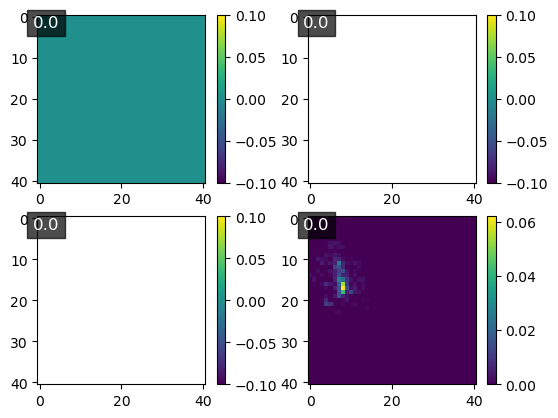

In [39]:
plot_image_2by2_v2(cpp_train_data_1,cpp_train_data_2,cpp_train_data_3,cpp_train_data_4,19,train_labels_multishape,string="cpptrain",dt=formatted_datetime)


Plotting Example Event. Event Nr:  19
Min. and Max. Value for Image 1:  0.0  -  1.0 . Sum:  22.266427041262183
Min. and Max. Value for Image 2:  0.0  -  1.0 . Sum:  11.081232994204468
Min. and Max. Value for Image 3:  0.0  -  0.0 . Sum:  0.0
Min. and Max. Value for Image 4:  0.0  -  1.0 . Sum:  11.17526964100092


FileNotFoundError: [Errno 2] No such file or directory: 'Test_images/Test_figure_evnr_19_train_2023-10-16_11-11.png'

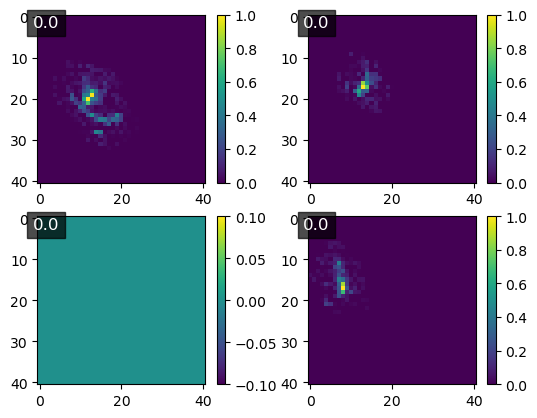

In [57]:
def custom_preprocess_input(data):
    # Perform custom preprocessing (e.g., scaling)
    max_values = np.max(data,axis=(2,3,4),keepdims=True)
    normalized_data = np.where(max_values == 0, data, data / max_values)    
        
    return normalized_data

#cpp_test_data_1 = custom_preprocess_input(test_data[:,0,:,:])
#cpp_test_data_2 = custom_preprocess_input(test_data[:,1,:,:])
#cpp_test_data_3 = custom_preprocess_input(test_data[:,2,:,:])
#cpp_test_data_4 = custom_preprocess_input(test_data[:,3,:,:])

#print(cpp_test_data_1.max())
#print(cpp_test_data_2.max())
#print(cpp_test_data_3.max())
#print(cpp_test_data_4.max())

#plot_image_2by2(train_data,19,train_labels_multishape,string="train",dt=formatted_datetime)
#plot_image_2by2_v2(cpp_test_data_1,cpp_test_data_2,cpp_test_data_3,cpp_test_data_4,4,train_labels_multishape,string="cpptrain",dt=formatted_datetime)
plot_image_2by2(normalized_data,19,train_labels_multishape,string="train",dt=formatted_datetime)



In [50]:
max_values = np.max(train_data,axis=(2,3,4),keepdims=True)
normalized_data = np.where(max_values == 0, train_data, train_data / max_values)

/tmp/ipykernel_15695/2283527740.py:2: RuntimeWarning: overflow encountered in divide
  normalized_data = np.where(max_values == 0, train_data, train_data / max_values)
/tmp/ipykernel_15695/2283527740.py:2: RuntimeWarning: invalid value encountered in divide
  normalized_data = np.where(max_values == 0, train_data, train_data / max_values)


In [58]:
import numpy as np

# Assuming 'data' is your array with shape (100, 4, 41, 41, 1)

# Step 1: Find the maximum value for each event
max_values = np.max(train_data, axis=(1, 2, 3, 4))

# Step 2: Normalize each event's images by its maximum value
normalized_data = train_data / max_values[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]


/tmp/ipykernel_15695/4232760514.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_data = train_data / max_values[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]


In [69]:
def custom_preprocess_input(data):
    normalized_data = np.empty(data.shape)
    # Perform custom preprocessing (e.g., scaling)
    #max_values = np.max(data,axis=(2,3,4),keepdims=True)
    for event in range(data.shape[0]):
        #max_values = np.max(data,axis=(1,2,3,4))
        #print(max_values)
        #normalized_data = np.where(max_values == 0, data, data / max_values[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis])   
        max_value = np.max(data[event])
        if max_value == 0:
            normalized_data[event] = data[event]
        else:
            data[event][np.isnan(data[event])] = 0
            normalized_data[event] = data[event]/max_value 
        
    return normalized_data
normalized_data = custom_preprocess_input(train_data)
print(np.max(normalized_data))

1.0


Plotting Example Event. Event Nr:  4
Min. and Max. Value for Image 1:  0.0  -  1.0 . Sum:  5.64365047977989
Min. and Max. Value for Image 2:  0.0  -  0.7040360061498745 . Sum:  5.254335105332514
Min. and Max. Value for Image 3:  0.0  -  0.7220262270730986 . Sum:  5.317837712289865
Min. and Max. Value for Image 4:  0.0  -  0.6986830805570056 . Sum:  5.3654323767756384


FileNotFoundError: [Errno 2] No such file or directory: 'Test_images/Test_figure_evnr_4_train_2023-10-16_11-11.png'

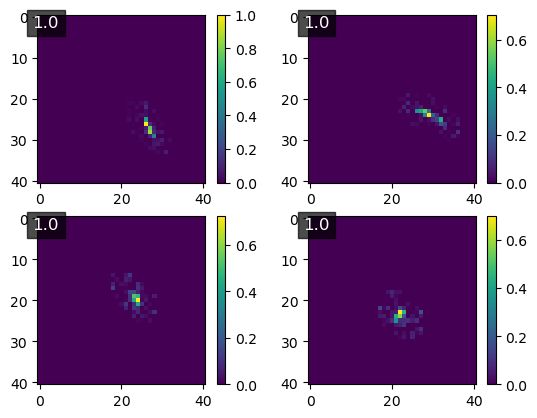

In [67]:
plot_image_2by2(normalized_data,4,train_labels_multishape,string="train",dt=formatted_datetime)

In [72]:
def preprocess_input_resnet(data):
    # Expand single-channel image to three channels
    rgb_data = np.repeat(data,3,axis=-1)
    mean = [103.939, 116.779, 123.68]
    std = None

    rgb_data[:,:,:,:,0] -= mean[0]
    rgb_data[:,:,:,:,1] -= mean[1]
    rgb_data[:,:,:,:,2] -= mean[2]
    return rgb_data

pp_train_data_1 = preprocess_input_resnet(train_data)

In [75]:
print(np.shape(pp_train_data_1))

(86, 4, 41, 41, 3)
